## Creating DataLoader

In [1]:
from cloud_dataset import CloudDataset
from pathlib import Path
from torchvision import transforms

path = Path('archive/38-Cloud_training')

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = CloudDataset(path/'train_red',
                       path/'train_green',
                       path/'train_blue',
                       path/'train_nir',
                       path/'train_gt',
                       transform)

print(f'Dataset size: {len(dataset)}')

Dataset size: 8400


In [2]:
import random

idx = random.randint(0, len(dataset) - 1)
x, y = dataset[idx]
print(f'Each sample shape: {x.shape}, {y.shape}')

Each sample shape: torch.Size([4, 128, 128]), torch.Size([128, 128])


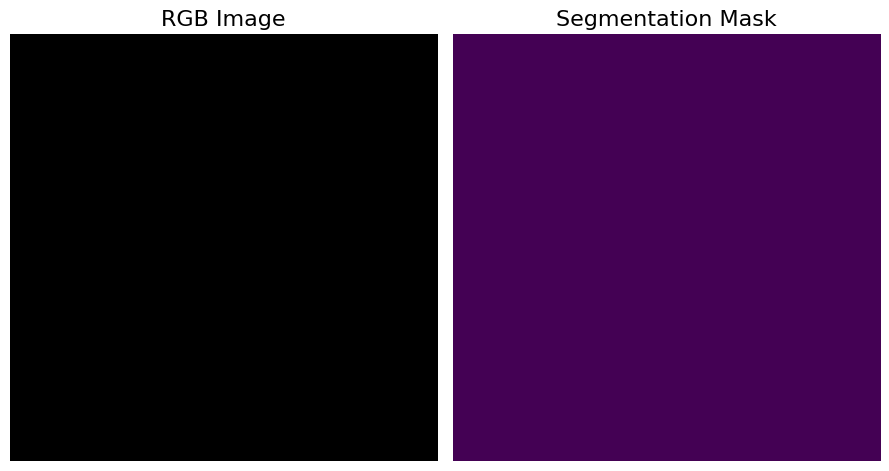

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))

ax[0].imshow(dataset.open_as_nparray(idx, invert=False, include_nir=False))
ax[0].set_title('RGB Image', fontsize=16)
ax[0].axis('off')

mask = dataset.open_mask(idx)
ax[1].imshow(mask)
ax[1].set_title('Segmentation Mask', fontsize=16)
ax[1].axis('off')

plt.tight_layout()

## DataLoader class: training and validation subsets

In [4]:
import torch
from torch.utils.data import random_split, DataLoader

torch.manual_seed(0)
train_ds, valid_ds = random_split(dataset, [0.8, 0.2])

batch_size = 32
torch.manual_seed(1310)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
print(f'Train size: {len(train_ds)}, Valid size: {len(valid_ds)}')

Train size: 6720, Valid size: 1680


In [5]:
"""xb, yb = next(iter(train_dl))
print(f'First batch shape: {xb.shape}, {yb.shape}')
# BatchSize x C x H x W"""

"xb, yb = next(iter(train_dl))\nprint(f'First batch shape: {xb.shape}, {yb.shape}')\n# BatchSize x C x H x W"

## Creating the model

![model_graph](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41598-019-53797-9/MediaObjects/41598_2019_53797_Fig1_HTML.png?as=webp)
Source: [Convolutional Neural Networks enable efficient, accurate and fine-grained segmentation of plant species and communities from high-resolution UAV imagery](https://www.nature.com/articles/s41598-019-53797-9) paper

In [6]:
from unet_model import UNet

unet = UNet(in_channels=4, out_channels=2)

# apply Xavier initialization to conv2D layers
def initialize_weights(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        
unet.apply(initialize_weights)

unet

UNet(
  (conv1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.1, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p

## Training the model

In [7]:
from train.train import *
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
unet.to(device)

torch.manual_seed(1310)
# binary cross entropy, with raw logits as the unet does not have a sigmoid final layer
#loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5.0]).to(device))
loss_fn = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(unet.parameters(), lr=0.01)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

epochs = 25

In [ ]:
#hists = train(unet, train_dl, valid_dl, loss_fn, optimizer, scheduler, epochs, device)
hists = train(unet, train_dl, valid_dl, loss_fn, optimizer, acc_metric, epochs)

Epoch 1/25 -------------------------
Current step: 50  Loss: 0.0985  Acc: 0.6153
Current step: 100  Loss: 0.0233  Acc: 0.6877


In [17]:
# save the trained model's state dictionary
torch.save(unet.state_dict(), 'unet_model.pth')

In [ ]:
# load the saved model weights in case i run it again
unet.load_state_dict(torch.load('unet_model.pth'))
"""
unet.eval()
unet.to(device)"""

In [10]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = unet(xb.cuda())

predb.shape

torch.Size([32, 2, 128, 128])

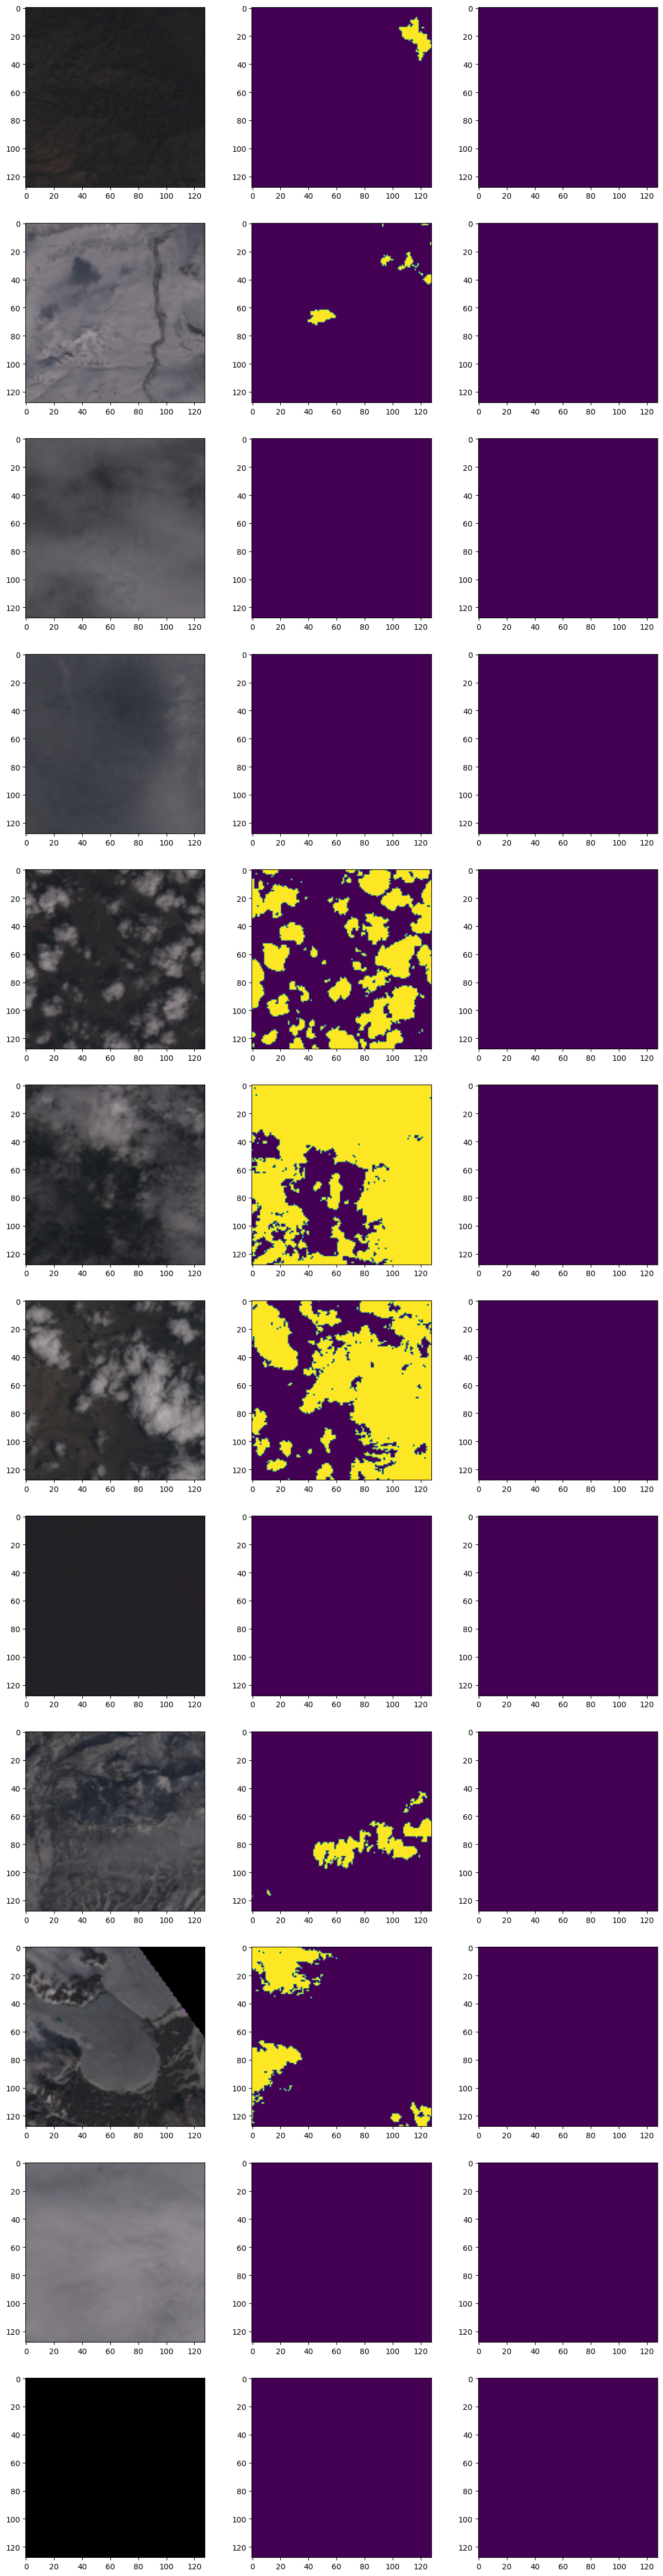

In [12]:
import numpy as np

bs = 12
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))